In this approach we will take the following steps:
1. Split customers into `train` and `validation` as 80%/20%
2. Scale data (fit_transform on `train` and only transform on `validation`)
3. Fit KMeans clusters with `train`, predict for `train`, add to `train` as a new feature predicted cluster
4. Predict for `validation`, add to `validation` as a new feature predicted cluster
5. Fit Support Vector Machine (Classifier) with `train` and predict for `validation`
6. Check results with classification report on predictions for `validation`

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.svm import SVC

import sys

%matplotlib inline
np.random.seed(59)

# set the max columns to none
pd.set_option('display.max_columns', None)

In [41]:
from preprocessing import *

path = 'data\\train.csv'

df = pd.read_csv(path)
df = convert_data(df)
df = engineer_features(df)
df = select_features(df)
df.head()

,account_length,international_plan,voice_mail_plan,number_vmail_messages,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn,total_minutes,total_calls,total_charge,area_code_area_code_408,area_code_area_code_415,area_code_area_code_510,state_MD,state_MN,state_NJ,state_TX,state_WV,state_other,avg_mt_minutes,avg_mt_calls,avg_mt_charge,avg_call_charge,avg_intl_call_charge,avg_call_minutes,avg_intl_call_minutes,both_plans
0,107,0,1,26,13.7,3,3.70,1,0,611.5,329,55.54,0,1,0,0,0,0,0,0,1,5.714953,3.074766,0.519065,0.168815,1.233333,1.858663,4.566667,0
1,137,0,0,0,12.2,5,3.29,0,0,527.2,328,59.00,0,1,0,0,0,1,0,0,0,3.848175,2.394161,0.430657,0.179878,0.658000,1.607317,2.440000,0
2,84,1,0,0,6.6,7,1.78,2,0,558.2,248,65.02,1,0,0,0,0,0,0,0,1,6.645238,2.952381,0.774048,0.262177,0.254286,2.250806,0.942857,0
3,75,1,0,0,10.1,3,2.73,3,0,501.9,356,49.36,0,1,0,0,0,0,0,0,1,6.692000,4.746667,0.658133,0.138652,0.910000,1.409831,3.366667,0
4,121,0,1,24,7.5,7,2.03,3,0,779.3,314,76.28,0,0,1,0,0,0,0,0,1,6.440496,2.595041,0.630413,0.242930,0.290000,2.481847,1.071429,0


Split the data to train and validation (without test)

In [42]:
X = df.drop('churn', axis=1)
y = df['churn']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2,
                                                  random_state=59)

Scaling

In [43]:
st_scaler = StandardScaler()

X_train_st = st_scaler.fit_transform(X_train)
X_val_st = st_scaler.transform(X_val)

Check the elbow, to determine what is the optimal number of clusters

In [45]:
km_list = list()

for i in range(1, 30):
    km = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=59)
    km = km.fit(X_train_st)
    
    km_list.append(pd.Series({'clusters': i, 
                              'inertia': km.inertia_,
                              'model': km}))

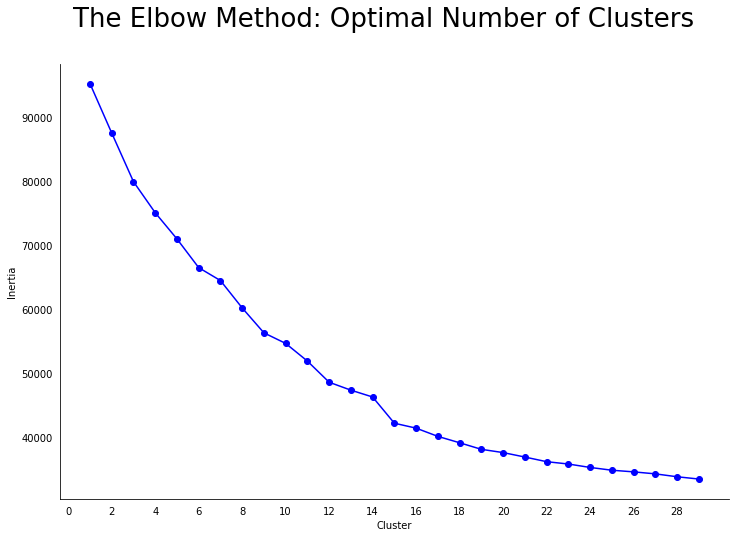

In [46]:
k = pd.concat(km_list, axis=1).T[['clusters','inertia']]

# Visualize
fig, ax = plt.subplots(figsize =(12, 8))
fig.patch.set_facecolor('white')

plt.plot(k['clusters'], k['inertia'], 'bo-')

# Remove ticks
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')

# Remove axes splines
for i in ['top','right']:
    ax.spines[i].set_visible(False)

ax.set_xticks(range(0, 30, 2))
ax.set(xlabel='Cluster', ylabel='Inertia')

plt.suptitle('The Elbow Method: Optimal Number of Clusters', size=26)
plt.show()

12 clusters is enough

In [47]:
kmeans = KMeans(n_clusters=12, max_iter=300, n_init=10, random_state=59)
kmeans.fit(X_train_st)

predicted_clusters_train = kmeans.predict(X_train_st)
X_train_st = np.column_stack((X_train_st, predicted_clusters_train))

predicted_clusters_val = kmeans.predict(X_val_st)
X_val_st = np.column_stack((X_val_st, predicted_clusters_val))

In [48]:
svm = SVC()
svm.fit(X_train_st, y_train)
y_pred = svm.predict(X_val_st)

In [49]:
from sklearn.metrics import classification_report, f1_score

print(classification_report(y_val, y_pred))
print('F1 Score', f1_score(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.92      1.00      0.95       732
           1       0.94      0.43      0.59       118

    accuracy                           0.92       850
   macro avg       0.93      0.71      0.77       850
weighted avg       0.92      0.92      0.90       850

F1 Score 0.5930232558139535


F1 Score = 0.59

To sum up: the biggest failure is in churn prediction (who would think), so it is important to somehow remove class imbalance (Oversample or Undesample)

With new engineered features F1 Score raised up to 0.59